# Lesson 28: TensorFlow/Keras neural network demonstration

## Notebook set up
### Imports

In [2]:
# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers, Model

## 1. Data preparation

### 1.1. Load California housing data

In [3]:
housing_df = pd.read_csv('https://gperdrizet.github.io/FSA_devops/assets/data/unit2/california_housing.csv')
housing_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [4]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [5]:
label = 'MedHouseVal'
features = ['MedInc','HouseAge','AveRooms','AveBedrms','Population','AveOccup','Latitude','Longitude']

### 1.2. Train test split

In [6]:
training_df, testing_df = train_test_split(housing_df, random_state=42)

### 1.3. Standard scale

#### Features

In [42]:
feature_scaler = StandardScaler()
feature_scaler.fit(training_df[features])

training_df[features] = feature_scaler.transform(training_df[features])
testing_df[features] = feature_scaler.transform(testing_df[features])


#### Label

In [8]:
label_scaler = StandardScaler()
label_scaler.fit(training_df[label].to_frame())

training_df[label] = label_scaler.transform(training_df[label].to_frame())
testing_df[label] = label_scaler.transform(testing_df[label].to_frame())

### 1.4. Handle outliers

In [9]:
for feature in features:

    q1 = training_df[feature].quantile(0.25)
    q3 = training_df[feature].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    training_df[feature] = training_df[feature].clip(lower=lower_bound, upper=upper_bound)
    testing_df[feature] = testing_df[feature].clip(lower=lower_bound, upper=upper_bound)

## 2. Linear regression baseline

### 2.1. Fit

In [10]:
linear_model = LinearRegression(n_jobs=-1)
fit_result = linear_model.fit(training_df[features], training_df[label])

### 2.2. Test set evaluation

In [11]:
linear_predictions = linear_model.predict(testing_df[features])
linear_rsquared = linear_model.score(testing_df[features], testing_df[label])
print(f'Linear regression R² on test set: {linear_rsquared:.4f}')

Linear regression R² on test set: 0.6586


## 3. Keras Sequential API model

The Sequential API is the simplest way to build a neural network in Keras. It allows you to create models layer-by-layer in a linear stack.

### 3.1. Build model

In [12]:
tf.random.set_seed(315)

sequential_model = keras.Sequential([
    layers.Input(shape=(8,)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
])

sequential_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

sequential_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

### 3.2. Train model

In [13]:
sequential_history = sequential_model.fit(
    training_df[features],
    training_df[label],
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

print('Training complete.')
print(f'Final training loss: {sequential_history.history["loss"][-1]:.4f}')
print(f'Final validation loss: {sequential_history.history["val_loss"][-1]:.4f}')

Epoch 1/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.4576 - mae: 0.5038 - val_loss: 0.3272 - val_mae: 0.4084
Epoch 2/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3377 - mae: 0.4236 - val_loss: 0.3080 - val_mae: 0.3885
Epoch 3/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.3088 - mae: 0.4013 - val_loss: 0.2898 - val_mae: 0.3768
Epoch 4/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2966 - mae: 0.3917 - val_loss: 0.2871 - val_mae: 0.3721
Epoch 5/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2878 - mae: 0.3851 - val_loss: 0.2792 - val_mae: 0.3659
Epoch 6/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2811 - mae: 0.3783 - val_loss: 0.2754 - val_mae: 0.3624
Epoch 7/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2759 - mae: 0.3762 - val_loss: 0.2672 - val_mae: 0.3578
Epoch 8/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2669 - mae: 0.3698 - val_loss: 0.2674 - val_mae: 0.3567
Epoch 9/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - lo

### 3.3. Learning curves

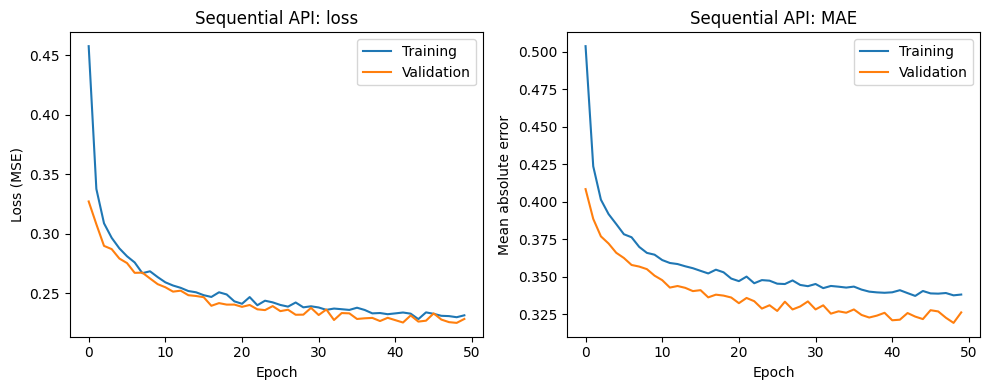

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].set_title('Sequential API: loss')
axes[0].plot(sequential_history.history['loss'], label='Training')
axes[0].plot(sequential_history.history['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend(loc='best')

axes[1].set_title('Sequential API: MAE')
axes[1].plot(sequential_history.history['mae'], label='Training')
axes[1].plot(sequential_history.history['val_mae'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Mean absolute error')
axes[1].legend(loc='best')

plt.tight_layout()
plt.show()

### 3.4. Test set evaluation

In [15]:
sequential_predictions = sequential_model.predict(testing_df[features], verbose=0).flatten()

ss_res = np.sum((testing_df[label] - sequential_predictions) ** 2)
ss_tot = np.sum((testing_df[label] - np.mean(testing_df[label])) ** 2)
sequential_rsquared = 1 - (ss_res / ss_tot)

print(f'Sequential API model R² on test set: {sequential_rsquared:.4f}')

Sequential API model R² on test set: 0.7805


### 3.5. Performance analysis

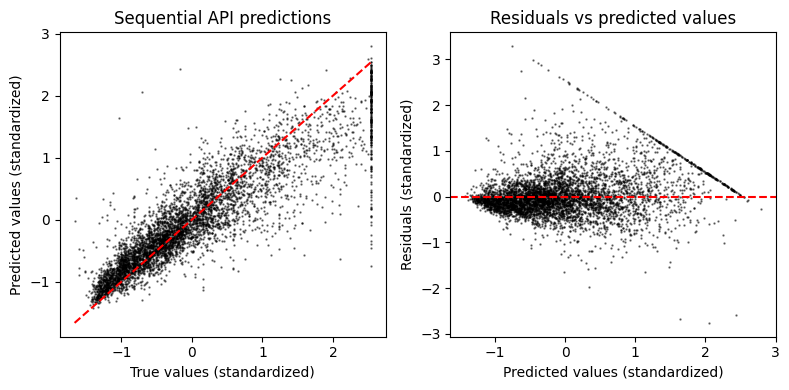

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('Sequential API predictions')
axes[0].scatter(
    testing_df[label], sequential_predictions,
    c='black', s=0.5, alpha=0.5
)
axes[0].plot(
    [testing_df[label].min(), testing_df[label].max()],
    [testing_df[label].min(), testing_df[label].max()],
    color='red', linestyle='--'
)
axes[0].set_xlabel('True values (standardized)')
axes[0].set_ylabel('Predicted values (standardized)')

axes[1].set_title('Residuals vs predicted values')
axes[1].scatter(
    sequential_predictions, testing_df[label] - sequential_predictions,
    c='black', s=0.5, alpha=0.5
)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_xlabel('Predicted values (standardized)')
axes[1].set_ylabel('Residuals (standardized)')

plt.tight_layout()
plt.show()

## 4. Keras Functional API model

The Functional API provides more flexibility than the Sequential API. It allows you to create models with non-linear topology, shared layers, and multiple inputs or outputs.

### 4.1. Build model

In [17]:
tf.random.set_seed(315)

# Define input layer
inputs = keras.Input(shape=(8,), name='input_features')

# Define hidden layers
x = layers.Dense(64, activation='relu', name='hidden_1')(inputs)
x = layers.Dropout(0.2, name='dropout_1')(x)
x = layers.Dense(32, activation='relu', name='hidden_2')(x)
x = layers.Dropout(0.2, name='dropout_2')(x)

# Define output layer
outputs = layers.Dense(1, name='output')(x)

# Create model
functional_model = Model(inputs=inputs, outputs=outputs, name='functional_mlp')

functional_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

functional_model.summary()

Model: "functional_mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_features (InputLayer)     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_1 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

### 4.2. Train model

In [24]:
functional_history = functional_model.fit(
    training_df[features],
    training_df[label],
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

print('Training complete.')
print(f'Final training loss: {functional_history.history["loss"][-1]:.4f}')
print(f'Final validation loss: {functional_history.history["val_loss"][-1]:.4f}')

Epoch 1/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2340 - mae: 0.3410 - val_loss: 0.2295 - val_mae: 0.3289
Epoch 2/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2314 - mae: 0.3378 - val_loss: 0.2300 - val_mae: 0.3256
Epoch 3/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2327 - mae: 0.3404 - val_loss: 0.2328 - val_mae: 0.3294
Epoch 4/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2314 - mae: 0.3401 - val_loss: 0.2308 - val_mae: 0.3279
Epoch 5/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2331 - mae: 0.3400 - val_loss: 0.2312 - val_mae: 0.3295
Epoch 6/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2313 - mae: 0.3407 - val_loss: 0.2263 - val_mae: 0.3271
Epoch 7/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2323 - mae: 0.3395 - val_loss: 0.2309 - val_mae: 0.3289
Epoch 8/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2324 - mae: 0.3389 - val_loss: 0.2321 - val_mae: 0.3279
Epoch 9/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

### 4.3. Learning curves

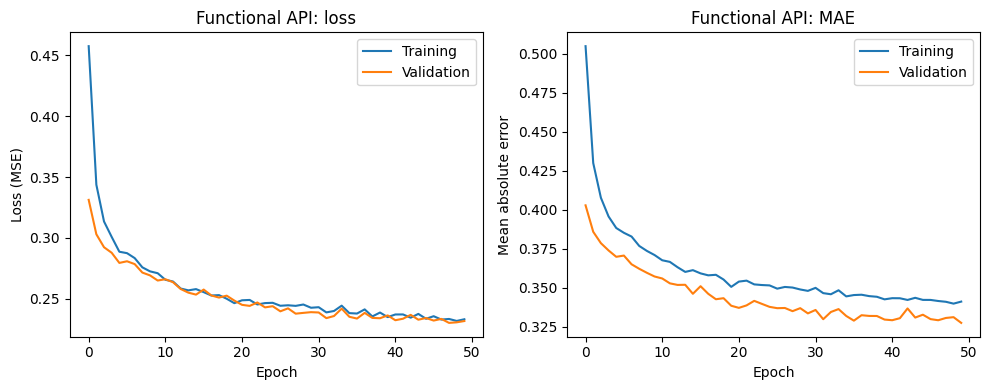

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].set_title('Functional API: loss')
axes[0].plot(functional_history.history['loss'], label='Training')
axes[0].plot(functional_history.history['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend(loc='best')

axes[1].set_title('Functional API: MAE')
axes[1].plot(functional_history.history['mae'], label='Training')
axes[1].plot(functional_history.history['val_mae'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Mean absolute error')
axes[1].legend(loc='best')

plt.tight_layout()
plt.show()

### 4.4. Test set evaluation

In [20]:
functional_predictions = functional_model.predict(testing_df[features], verbose=0).flatten()

ss_res = np.sum((testing_df[label] - functional_predictions) ** 2)
ss_tot = np.sum((testing_df[label] - np.mean(testing_df[label])) ** 2)
functional_rsquared = 1 - (ss_res / ss_tot)

print(f'Functional API model R² on test set: {functional_rsquared:.4f}')

Functional API model R² on test set: 0.7799


### 4.5. Performance analysis

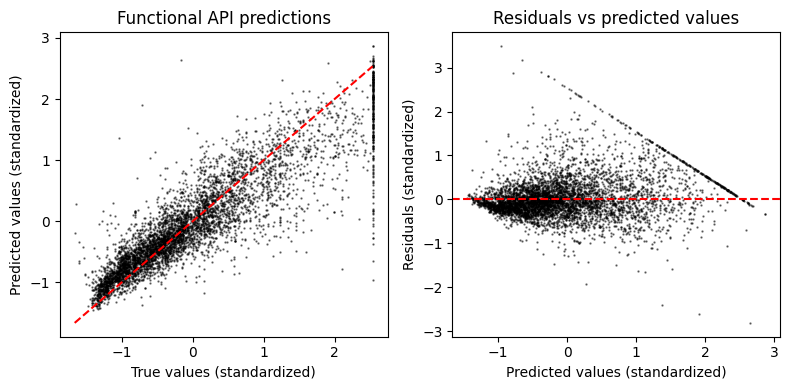

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('Functional API predictions')
axes[0].scatter(
    testing_df[label], functional_predictions,
    c='black', s=0.5, alpha=0.5
)

axes[0].plot(
    [testing_df[label].min(), testing_df[label].max()],
    [testing_df[label].min(), testing_df[label].max()],
    color='red', linestyle='--'
)

axes[0].set_xlabel('True values (standardized)')
axes[0].set_ylabel('Predicted values (standardized)')

axes[1].set_title('Residuals vs predicted values')
axes[1].scatter(
    functional_predictions, testing_df[label] - functional_predictions,
    c='black', s=0.5, alpha=0.5
)

axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_xlabel('Predicted values (standardized)')
axes[1].set_ylabel('Residuals (standardized)')

plt.tight_layout()
plt.show()

## 5. Model comparison

In [22]:
print(f'Linear regression R² on test set: {linear_rsquared:.4f}')
print(f'Sequential API model R² on test set: {sequential_rsquared:.4f}')
print(f'Functional API model R² on test set: {functional_rsquared:.4f}')

Linear regression R² on test set: 0.6586
Sequential API model R² on test set: 0.7805
Functional API model R² on test set: 0.7799


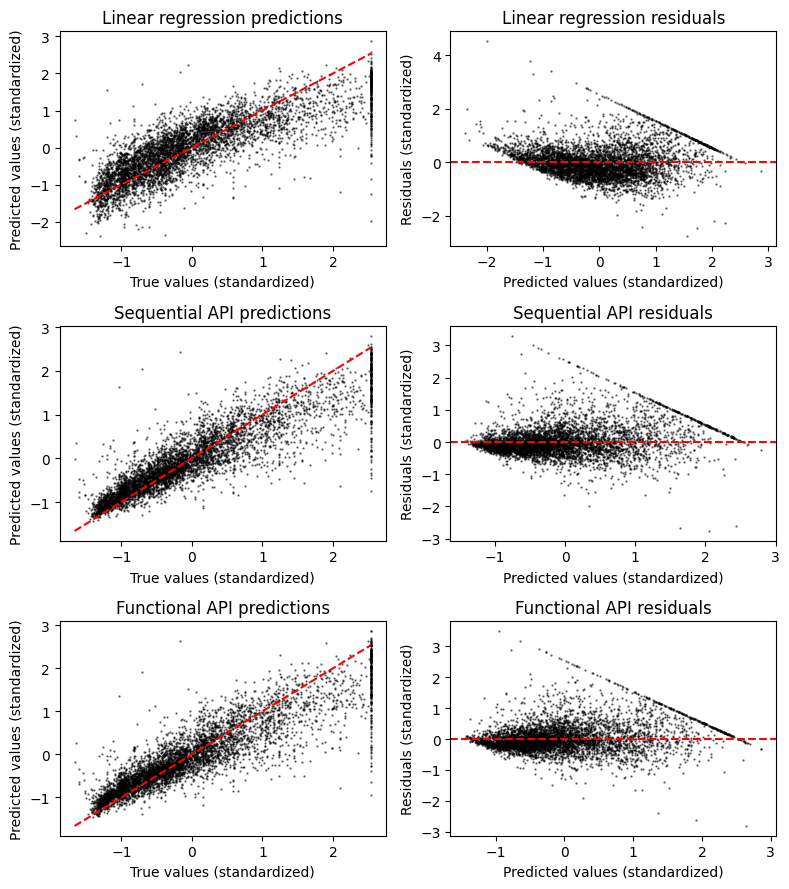

In [23]:
fig, axes = plt.subplots(3, 2, figsize=(8, 9))

# Linear regression
axes[0, 0].set_title('Linear regression predictions')
axes[0, 0].scatter(
    testing_df[label], linear_predictions,
    c='black', s=0.5, alpha=0.5
)

axes[0, 0].plot(
    [testing_df[label].min(), testing_df[label].max()],
    [testing_df[label].min(), testing_df[label].max()],
    color='red', linestyle='--'
)

axes[0, 0].set_xlabel('True values (standardized)')
axes[0, 0].set_ylabel('Predicted values (standardized)')

axes[0, 1].set_title('Linear regression residuals')
axes[0, 1].scatter(
    linear_predictions, testing_df[label] - linear_predictions,
    c='black', s=0.5, alpha=0.5
)

axes[0, 1].axhline(0, color='red', linestyle='--')
axes[0, 1].set_xlabel('Predicted values (standardized)')
axes[0, 1].set_ylabel('Residuals (standardized)')

# Sequential API
axes[1, 0].set_title('Sequential API predictions')
axes[1, 0].scatter(
    testing_df[label], sequential_predictions,
    c='black', s=0.5, alpha=0.5
)

axes[1, 0].plot(
    [testing_df[label].min(), testing_df[label].max()],
    [testing_df[label].min(), testing_df[label].max()],
    color='red', linestyle='--'
)

axes[1, 0].set_xlabel('True values (standardized)')
axes[1, 0].set_ylabel('Predicted values (standardized)')

axes[1, 1].set_title('Sequential API residuals')
axes[1, 1].scatter(
    sequential_predictions, testing_df[label] - sequential_predictions,
    c='black', s=0.5, alpha=0.5
)

axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].set_xlabel('Predicted values (standardized)')
axes[1, 1].set_ylabel('Residuals (standardized)')

# Functional API
axes[2, 0].set_title('Functional API predictions')
axes[2, 0].scatter(
    testing_df[label], functional_predictions,
    c='black', s=0.5, alpha=0.5
)

axes[2, 0].plot(
    [testing_df[label].min(), testing_df[label].max()],
    [testing_df[label].min(), testing_df[label].max()],
    color='red', linestyle='--'
)

axes[2, 0].set_xlabel('True values (standardized)')
axes[2, 0].set_ylabel('Predicted values (standardized)')

axes[2, 1].set_title('Functional API residuals')
axes[2, 1].scatter(
    functional_predictions, testing_df[label] - functional_predictions,
    c='black', s=0.5, alpha=0.5
)

axes[2, 1].axhline(0, color='red', linestyle='--')
axes[2, 1].set_xlabel('Predicted values (standardized)')
axes[2, 1].set_ylabel('Residuals (standardized)')

plt.tight_layout()
plt.show()